## 0. Install and Import Dependencies

In [1]:
#!pip install easyocr
#!pip install imutils

In [2]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## 1. Read in Image, Grayscale and Blur

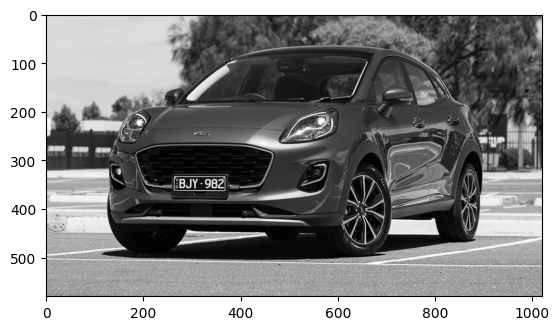

In [4]:
image = cv2.imread('image3.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

In [6]:
plate_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_russian_plate_number.xml')
plates = plate_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

plate_images = []
for (x, y, w, h) in plates:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plate_images.append(gray[y:y + h, x:x + w])
plate_images

[array([[51, 54, 54, ..., 56, 57, 58],
        [43, 46, 46, ..., 56, 56, 57],
        [12, 20, 20, ..., 58, 58, 58],
        ...,
        [35, 32, 31, ...,  9,  9,  9],
        [33, 29, 29, ...,  9,  9,  9],
        [29, 26, 26, ...,  9,  9,  9]], dtype=uint8)]